# Construct a trajectory one step at a time

We aim to predict the next steps and actions based on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

from Process_Training_Data import class_to_action
from Process_Training_Data import norm

importing Jupyter notebook from Process_Training_Data.ipynb
Empty DataFrame
Columns: [id_camino, D0, D1, D2, D3, D4, D5, out_action, A0, A1]
Index: []


## Multi-step model using single step-multioutput model

In [5]:
model = tf.keras.models.load_model('./data/S2S_S2A_model.h5')

In [6]:
data_stats = pd.read_csv("./data/data_stats.csv")

In [7]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [8]:
from simulate_clean import get_next_state
from clean_model import tc, c
from classes import FlightState

In [9]:
def distance_error(x, z, pitch, u, v):
    distancia = math.sqrt(x**2 + z**2)
    # distancia = math.sqrt(x**2 + z**2 + pitch**2 + u**2 + v**2)
    return distancia

In [10]:
def generate_trajectory(model, start, target, initial_action):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 6

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],target[6], target[7])
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],start[6], start[7])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = norm(distance_long[0:6], data_stats)
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:5])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()

  boolean = True

  while boolean:
      predictions = model(input_eval)
      # remove the batch dimension
      action = tf.squeeze(predictions, 0)
      
      actions.append(np.array(action))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean < 0:
        end_message = "Error"
        break

      # We pass the predicted point as the next input to the model
      # along with the previous hidden state
      FS_current_state = FS_new_state
      current_state= FS_current_state.get_info_formatted()
      distance_long = target - current_state

      distance = norm(distance_long[0:6], data_stats)
      input_eval = tf.expand_dims([distance], 0)

      trajectory_generated.append(distance)

      cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
      distancia_error = 0.5*c*distance_error(*distance_long[0:5])          

      end_message = "End"
  print(end_message)  
  return trajectory_generated, cost, distancia_error, actions, end_message

In [11]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [19]:
sample_id = 7
initial_action = np.array(samples['h_actions'][sample_id][0])
start = np.array(samples['initial_state'][sample_id])
target = np.array(samples['final_state'][sample_id])
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(norm(sample[0:6],data_stats))
teorico = np.array(teorico)

In [20]:
trajectory, cost, distancia_error, actions, end_message= generate_trajectory(model, start, target, initial_action)
trajectory = np.array(trajectory)



End


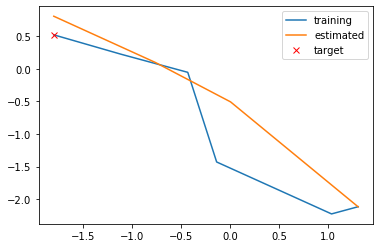

666.5936311933083
5.49024268413288


In [21]:
plt.plot(teorico[:,0], teorico[:,1],  label="training")
plt.plot(trajectory[:,0], trajectory[:,1], label="estimated")
D0 = norm([0,0,0,0,0,0], data_stats)
plt.plot(D0[0], D0[1],"rx", label="target")
plt.legend()
plt.show()
print(cost)
print(distancia_error)

In [15]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(results['h_actions'][sample_id][0])
    start = np.array(results['initial_state'][sample_id])
    target = np.array(results['final_state'][sample_id])
    start_time = time.time()
    trajectory, cost, distancia_error, actions, end_message = generate_trajectory(model, start, target, initial_action)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distancia_error
    results.at[sample_id, 'end_message'] = end_message
    

    

0
End
1
End
2
End
3
End
4
End
5
End
6
End
7
End
8
End
9
End
10
End
11
End
12
End
13
End
14
End
15
End
16
End
17
End
18
End
19
End
20
End
21
End
22
End
23
End
24
End
25
End
26
End
27
End
28
End
29
End
30
End
31
End
32
End
33
End
34
End
35
End
36
End
37
End
38
odeint esta hervi'o
Error
39
End
40
End
41
odeint esta hervi'o
Error
42
End
43
End
44
End
45
End
46
End
47
End
48
End
49
End
50
End
51
End
52
End
53
End
54
End
55
End
56
End
57
End
58
End
59
End
60
End
61
End
62
End
63
End
64
End
65
End
66
End
67
End
68
End
69
End
70
End
71
End
72
End
73
End
74
End
75
End
76
End
77
End
78
End
79
End
80
End
81
End
82
End
83
End
84
End
85
End
86
End
87
End
88
End
89
End
90
End
91
End
92
End
93
End
94
End
95
End
96
End
97
End
98
End
99
End


In [16]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table



,sample,result_end,result_error
h_cost,5215.39,3823.8,59.9387
h_distance,3.95573,41.4591,187.587
h_time,388.612,1.58935,0.624362


In [17]:
np.sum(results["end_message"] == "Error")

2

In [18]:
results.to_csv(r"./data/RNN_samples_metric_S2A.csv")